# MXNet Numpy
Briefly describe what are we going to talk about


In [1]:
# a bit of setup

import matplotlib.pyplot as plt

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
import numpy as np
import numpy.random as random
import time
from util import get_data, plot_data

# Initialize data and weight

data, label = get_data()
num_samples = data.shape[0]
num_features = data.shape[1]
num_classes = label.shape[1]

weight = random.randn(num_features, num_classes)

print 'Shapes: data {}, label {}, w {}'.format(data.shape, label.shape, weight.shape)
print '# samples: {}'.format(num_samples)
print '# features: {}'.format(num_features)
print '# classes: {}'.format(num_classes)

Shapes: data (10000, 500), label (10000, 5), w (500, 5)
# samples: 10000
# features: 500
# classes: 5


## Logistic regression using Numpy

In [3]:
# predict the class using logistic regression
def predict(w, x):
    a = np.exp(np.dot(x, w))
    a_sum = np.sum(a, axis=1, keepdims=True)
    prob = a / a_sum
    return prob

Ground truth


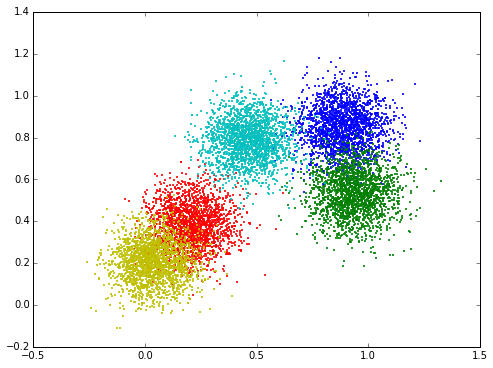

In [4]:
# Visualize what the ground truth data looks like
print 'Ground truth'
plot_data(data, label)

Initial Guess


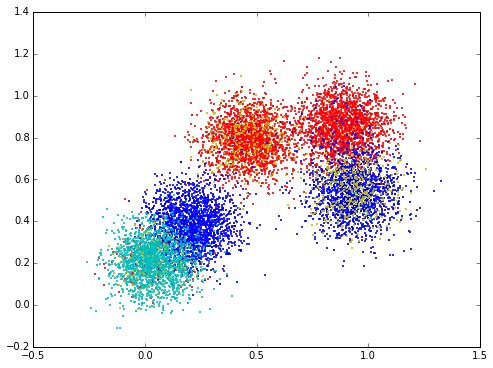

In [5]:
# Visualize the initial guess
print 'Initial Guess'
plot_data(data, predict(weight, data))

In [6]:
# Using gradient descent to fit the correct classes
def train(w, x, loops):
    for i in range(loops):
        prob = predict(w, x)
        if i % 10 == 0:
            print 'Iter {}, training loss {}'.format(i, -np.sum(np.log(prob) * label) / num_samples)
        # calculate gradient of weight
        dy = prob - label
        dw = np.dot(data.T, dy) / num_samples
        w -= 0.1 * dw

# Now training it for 100 iterations
start_time = time.time()
train(weight, data, 100)
print 'Training time: {}s'.format(time.time() - start_time)

Iter 0, training loss 12.9227967798
Iter 10, training loss 1.44732635322
Iter 20, training loss 0.291549257838
Iter 30, training loss 0.132531629638
Iter 40, training loss 0.081142719028
Iter 50, training loss 0.0570877765218
Iter 60, training loss 0.043465178525
Iter 70, training loss 0.0348090622923
Iter 80, training loss 0.0288691186372
Iter 90, training loss 0.0245632486898
Training time: 8.82987713814s


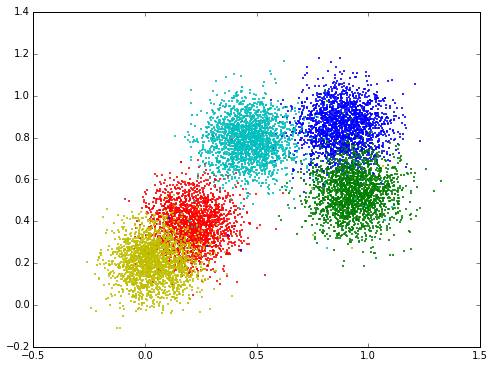

In [7]:
# Plot the prediction after training. It should show similar image as the ground truth.
plot_data(data, predict(weight, data))

## Logistic regression using MXNet Numpy

### Utilize GPU computation with little (or no) numpy syntax change

In [8]:
import minpy.numpy as np
import minpy.numpy.random as random

I[0401 18:49:37 24327 mocking.py:25:__init__] Initialize module: minpy.numpy.random
I[0401 18:49:37 24327 mocking.py:33:__init__] Importing from minpy.array_variants.numpy.random
I[0401 18:49:37 24327 mocking.py:40:__init__] Got 52 primitives from minpy.array_variants.numpy.random
I[0401 18:49:37 24327 mocking.py:33:__init__] Importing from minpy.array_variants.mxnet.random
I[0401 18:49:37 24327 mocking.py:40:__init__] Got 2 primitives from minpy.array_variants.mxnet.random
I[0401 18:49:37 24327 mocking.py:44:__init__] Import 54 primitives
I[0401 18:49:37 24327 mocking.py:25:__init__] Initialize module: minpy.numpy
I[0401 18:49:37 24327 mocking.py:33:__init__] Importing from minpy.array_variants.numpy
I[0401 18:49:37 24327 mocking.py:40:__init__] Got 388 primitives from minpy.array_variants.numpy
I[0401 18:49:37 24327 mocking.py:33:__init__] Importing from minpy.array_variants.mxnet
I[0401 18:49:37 24327 mocking.py:40:__init__] Got 20 primitives from minpy.array_variants.mxnet
I[0401 1

In [9]:
# Initialize weight matrix (again)
weight = random.randn(num_features, num_classes)

# Now training it for 100 iterations
start_time = time.time()
train(weight, data, 100)
print 'Training time: {}s'.format(time.time() - start_time)

Iter 0, training loss 25.045634375
Iter 10, training loss 0.633512207031
Iter 20, training loss 0.198342028809
Iter 30, training loss 0.10624375
Iter 40, training loss 0.0698764099121
Iter 50, training loss 0.0510560089111
Iter 60, training loss 0.0397542633057
Iter 70, training loss 0.0322982879639
Iter 80, training loss 0.0270500579834
Iter 90, training loss 0.0231762771606
Training time: 3.41191411018s


### Automatic gradient calculation

In [11]:
from minpy.core import grad_and_loss

# Initialize weight matrix (again)
weight = random.randn(num_features, num_classes)

# Using gradient descent to fit the correct classes
def train_loss(w, x):
    prob = predict(w, x)
    return -np.sum(np.log(prob) * label) / num_samples

# Calculate gradient function automatically
grad_function = grad_and_loss(train_loss)

# Now training it for 100 iterations
start_time = time.time()
for i in range(100):
    dw, loss = grad_function(weight, data)
    if i % 10 == 0:
        print 'Iter {}, training loss {}'.format(i, loss)
    weight -= 0.1 * dw
print 'Training time: {}s'.format(time.time() - start_time)

Iter 0, training loss 12.5030234375
Iter 10, training loss 1.07578828125
Iter 20, training loss 0.226699560547
Iter 30, training loss 0.106715734863
Iter 40, training loss 0.0662076660156
Iter 50, training loss 0.0468475067139
Iter 60, training loss 0.0357586120605
Iter 70, training loss 0.0286656494141
Iter 80, training loss 0.0237792358398
Iter 90, training loss 0.02022865448
Training time: 3.76882886887s
